In [1]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import torch_func
from diff_func_fitters import fit_polynomial, fit_rational_func, SumFunc, FiniteDiffFunc1D
from baryrat import aaa
from gauss_freud_quad import get_nodes_and_weights
import mgo
from scipy.signal import find_peaks

import util as ut

In [2]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

### Dispersion Relation

In [3]:
def E(nu):
    return nu + 1/2

def R(nu):
    return np.sqrt(2*E(nu))

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar'), nu: ('scalar')):
    return - x**2 - k**2 + 2*E(nu)

def get_k0(x0, nu):
    return np.sqrt(np.round(2*E(nu) - x0**2, 4))

In [4]:
from scipy.special import airy

def Ai(x):
    ai, *_ = airy(x)
    return ai

def Bi(x):
    _, _, bi, _ = airy(x)
    return bi

rho_ex = lambda x, nu: (R(nu)**(2/3) * np.sqrt(R(nu)**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x, nu: (x * np.sqrt(R(nu)**2-x**2) / 2
                          - R(nu)**2 * np.arccos(x/R(nu))/2
                          + 2/3 * (rho_ex(x, nu)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )
phi0 = lambda x0, nu: (Ai(-(rho_ex(x0, nu)**2)) * np.cos(omega_bar_ex(x0, nu)) / np.sqrt(np.abs(x0))
                      - np.sign(x0) * Bi(-rho_ex(x0, nu)**2) * np.sin(omega_bar_ex(x0, nu)) / np.sqrt(np.abs(x0))
                      )

In [5]:
def get_dispersion_manifold(nu, x0, k0):
    '''returns t, xs, ks, zs, nt, i_start, i_end, x0, k0'''
    nt = 500
    omega0 = 1.0
    t, xs, ks, zs, i_start, i_end = trace_ray_1D(x0=x0, k0=k0, omega0=omega0, tmin=-np.pi/2, tmax=np.pi, D=D, D_args={'nu': nu}, x_min=(1-1e-3)*x0, tsteps=nt, rtol=1e-9, ghost_ratio=1)
    nt = i_end - i_start
    return t, xs, ks, zs, nt, i_start, i_end, x0, k0

def fit_amplitude(x, y, nu):
    tmp_fit = fit_polynomial(x, y**(-4), deg=2, exclude_degrees=[1])
    return lambda eps: tmp_fit(eps)**(-1/4)

def fit_phase(x, y, nu):
    nonlinear_func = FiniteDiffFunc1D(lambda eps: eps/2 * np.emath.sqrt(R(nu)**2 - eps**2) + R(nu)**2/2 * np.arcsin(eps/R(nu)))
    y_poly = y - nonlinear_func(x)
    polynomial = fit_polynomial(x, y_poly, deg=2, exclude_degrees=[0])
    return SumFunc([polynomial, nonlinear_func])

def get_mgo_field(t, zs, analytic_cont, i_start, i_end, i_save=[], max_gauss_quad_order=10):
    branch_masks, ray_field, mgo_info = mgo.get_mgo_field(t, zs, phi0=1, i_start=i_start, i_end=i_end, i_save=i_save, analytic_cont=analytic_cont, max_gauss_quad_order=max_gauss_quad_order)
    results = mgo_info['saved_results']
    Nt = mgo_info['Nt']
    Upsilon = mgo_info['Upsilon']
    return branch_masks, ray_field, mgo_info, results, Nt, Upsilon

In [6]:
from scipy.special import hermite, factorial
psi = lambda x, nu: (2**nu * factorial(nu))**(-1/2) * hermite(nu)(x) * np.exp(-x**2/2)

#### MGO Results

In [42]:
nus = np.arange(5)
x0s = {}
fields_ex = {}
# fields_rational = {}
fields_aaa = {}
fields_go = {}

for i, nu in enumerate(nus[::-1]):
    x0 = -R(nu)
    x0s[nu] = x0

    k0 = get_k0(x0, nu)
    phi0 = psi(x0, nu)
    t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(nu, x0, k0)
    gradtau_x = fd.grad(xs.squeeze(), t)[i_start:i_end]
    J = gradtau_x.squeeze()

    x_tmp = np.linspace(-R(nu), R(nu), 10000)
    x1 = x_tmp[find_peaks(psi(x_tmp, nu))[0][0]]
    phi1 = psi(x1, nu)

    phi1 = phi1
    x1 = x1

    t_GO, xs_GO, zs_GO = t[i_start:i_end][J != 0], xs[i_start:i_end][J != 0], zs[i_start:i_end][J != 0]
    i_start_GO, i_end_GO = 0, len(t_GO)
    branch_masks_GO, ray_field_GO = mgo.get_go_field_1D(t_GO, zs_GO, phi0=1, i_start=i_start_GO, i_end=i_end_GO)
    field_GO = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs_GO, branch_masks=branch_masks_GO, ray_field=ray_field_GO, i_start=i_start_GO, i_end=i_end_GO)
    fields_go[nu] = field_GO

    analytic_cont = {'phase': {'fit_func': fit_phase, 'kwargs': {'nu': nu}}, 'amplitude': {'fit_func': fit_amplitude, 'kwargs': {'nu': nu}}}
    branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(t, zs, analytic_cont, i_start, i_end)
    field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
    fields_ex[nu] = field

    # analytic_cont={'phase': {'fit_func': fit_rational_func, 'kwargs': {'L': 6, 'M': 3, 'optimize': False}},
    #                'amplitude': {'fit_func': fit_rational_func, 'kwargs': {'L': 2, 'M': 2, 'optimize': False}}}
    # branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(t, zs, analytic_cont, i_start, i_end)
    # field = mgo.superpose_ray_fields(phi0=phi0, x0=x0, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
    # fields_rational[nu] = field

    analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}},
                   'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}}
    branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(t, zs, analytic_cont, i_start, i_end, i_save=[])
    field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
    fields_aaa[nu] = field

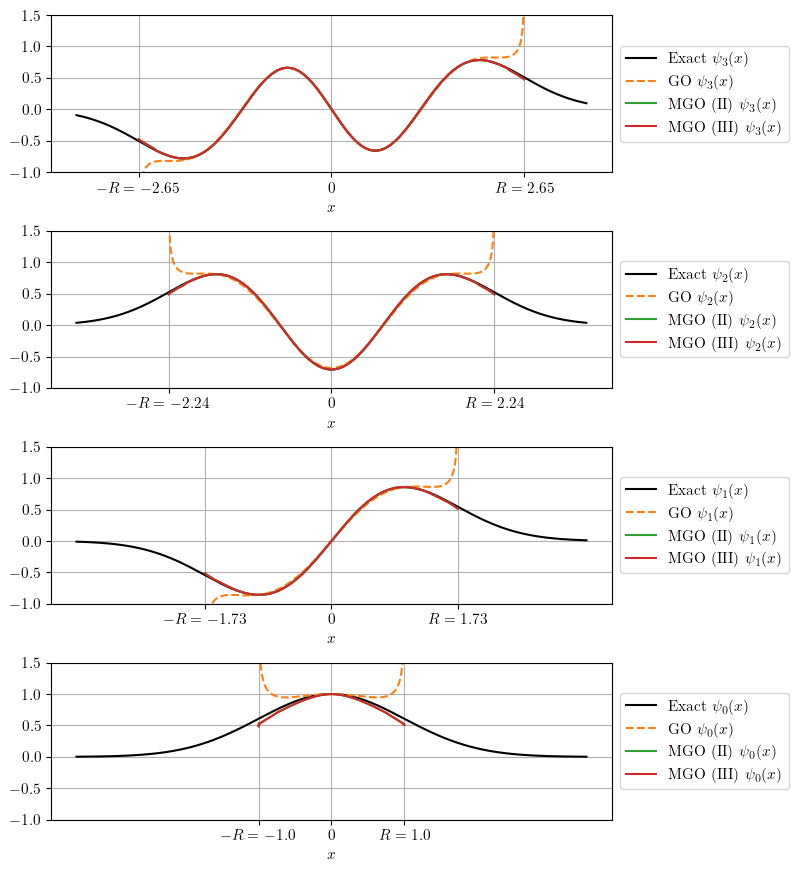

In [43]:
x = np.linspace(-3.5, 3.5, 1000)
fig, ax = plt.subplots(len(nus[:-1]), 1, figsize=(8,2.2*len(nus[:-1])))
for i, nu in enumerate(nus[:-1][::-1]):
    xi = np.linspace(-R(nu), R(nu), 10000)
    ax[i].plot(x, psi(x, nu), 'k-', label='Exact $\psi_' + str(nu) + '(x)$')
    ax[i].plot(xi, np.real(fields_go[nu](xi)), '--', color='tab:orange', label='GO $\psi_' + str(nu) + '(x)$')
    # ax[i].plot(xi, np.real(fields_rational[nu](xi)), '-', color='tab:blue', label='MGO (I) $\psi_' + str(nu) + '(x)$')
    ax[i].plot(xi, np.real(fields_ex[nu](xi)), '-', color='tab:green', label='MGO (II) $\psi_' + str(nu) + '(x)$')
    ax[i].plot(xi, np.real(fields_aaa[nu](xi)), '-', color='tab:red', label='MGO (III) $\psi_' + str(nu) + '(x)$')
    ax[i].grid()
    ax[i].set_ylim(-1, 1.5)
    ax[i].set_xticks([-R(nu), 0, R(nu)], labels=[r'$-R = ' + str(round(-R(nu), 2)) + '$', r'$0$', r'$R = '+ str(round(R(nu), 2)) + '$'])
    ax[i].legend(bbox_to_anchor=(1,0.5), loc="center left")
    ax[i].set_xlabel('$x$')
    # ax[i].set_title(r'$\nu = ' + str(nu) + '$')
fig.tight_layout()
# plt.savefig('./plots/weber_mgo.pdf')
# plt.savefig('./plots/weber_mgo.png', dpi=300)
plt.show()

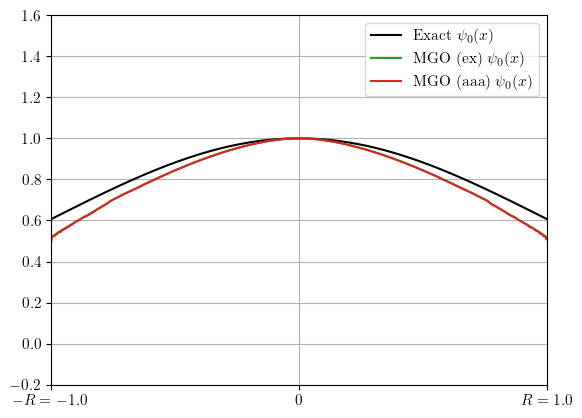

In [44]:
xi = np.linspace(-R(nu), R(nu), 500)
plt.plot(x, psi(x, nu), 'k-', label='Exact $\psi_' + str(nu) + '(x)$')
plt.plot(xi, np.real(fields_ex[nu](xi)), '-', color='tab:green', label='MGO (ex) $\psi_' + str(nu) + '(x)$')
plt.plot(xi, np.real(fields_aaa[nu](xi)), '-', color='tab:red', label='MGO (aaa) $\psi_' + str(nu) + '(x)$')
plt.ylim(-0.2, 1.6)
plt.xlim(-R(nu), R(nu))
plt.xticks([-R(nu), 0, R(nu)], labels=[r'$-R = ' + str(round(-R(nu), 2)) + '$', r'$0$', r'$R = '+ str(round(R(nu), 2)) + '$'])
plt.grid()
plt.legend()
plt.show()

#### GO Results

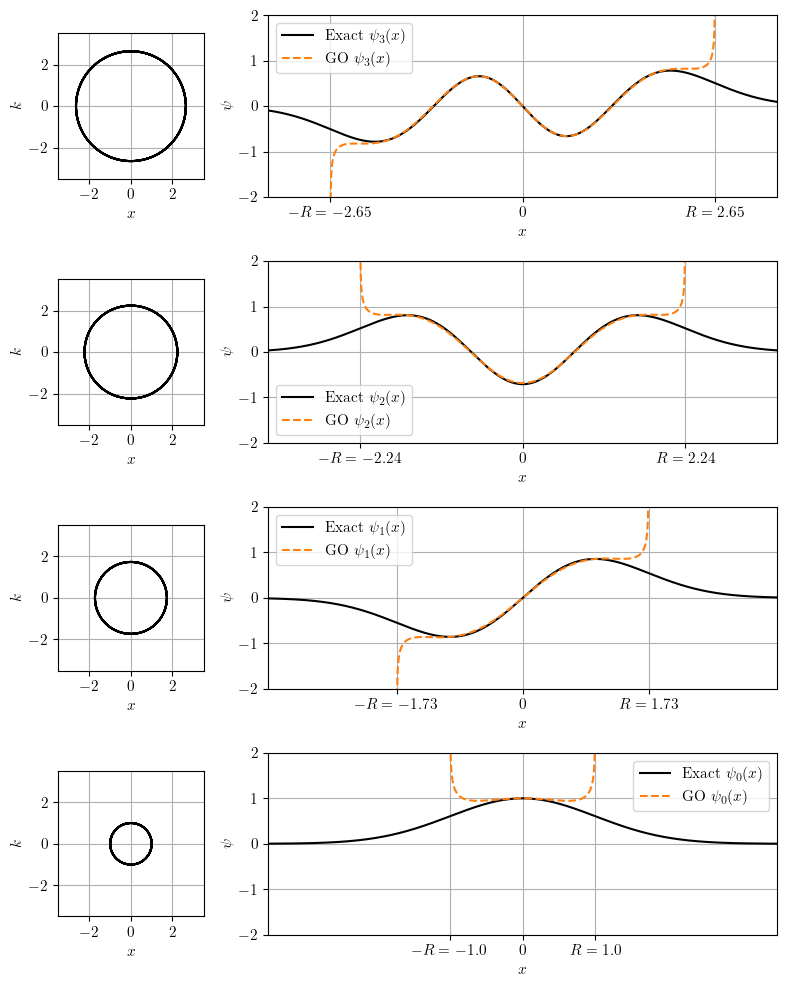

In [45]:
x = np.linspace(-3.5, 3.5, 1000)
fig, ax = plt.subplots(len(nus[:-1]), 2, figsize=(8,2.5*len(nus[:-1])), width_ratios=[2, 7])
for i, nu in enumerate(nus[:-1][::-1]):
    x0 = -R(nu)
    k0 = get_k0(x0, nu)
    t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(nu, x0, k0)
    ax[i, 0].grid()
    ax[i, 0].plot(xs, ks, 'k-')
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$k$')
    ax[i, 0].set_xticks([-2, 0, 2])
    ax[i, 0].set_aspect('equal',adjustable='box')
    ax[i, 0].set_xlim(np.min(x), np.max(x))
    ax[i, 0].set_ylim(np.min(x), np.max(x))
    ax[i, 0].set_xbound(np.min(x), np.max(x))
    # ax[i, 0].set_ylim(np.min(x), np.max(x))

    xi = np.linspace(-R(nu), R(nu), 10000)
    ax[i, 1].plot(x, psi(x, nu), 'k-', label='Exact $\psi_' + str(nu) + '(x)$')
    ax[i, 1].plot(xi, np.real(fields_go[nu](xi)), '--', color='tab:orange', label='GO $\psi_' + str(nu) + '(x)$')
    ax[i, 1].grid()
    ax[i, 1].set_xlim(np.min(x), np.max(x))
    ax[i, 1].set_ylim(-2, 2)
    ax[i, 1].set_xticks([-R(nu), 0, R(nu)], labels=[r'$-R = ' + str(round(-R(nu), 2)) + '$', r'$0$', r'$R = '+ str(round(R(nu), 2)) + '$'])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$\psi$')
    # ax[i].set_title(r'$\nu = ' + str(nu) + '$')
fig.tight_layout()
plt.savefig('./plots/weber_GO.pdf')
plt.savefig('./plots/weber_GO.png', dpi=300)
plt.show()

#### Inspection at different time points

In [46]:
xs_ex = lambda t: R(nu) * np.cos(2*t)
ks_ex = lambda t: - R(nu) * np.sin(2*t)
A_ex = lambda t: -np.sin(2*t)
B_ex = lambda t: -np.cos(2*t)
B_phase = lambda t: np.pi * np.floor((4*t-np.pi)/(2*np.pi))
sigma_t_ex = lambda t: np.exp(-1j * np.pi * np.floor((4*t+np.pi)/(4*np.pi)))
Nt_ex = lambda t: (np.exp(1j*t*(R(nu)**2) - 1j * ((R(nu)**2)/4) * np.sin(4*t))
                    / (
                        np.emath.sqrt(-1j*2*np.pi*2*R(nu))
                        * ut.continuous_sqrt_of_reals(B_ex(t))
                    ))

s = lambda t: -np.sign(np.tan(2*t))
Upsilon_ex = lambda t: ( np.pi * ((2*R(nu))**(1/3))
                            * np.exp(-1j * (R(nu)**2)/3 * ((np.tan(2*t))**3) )
                            * (
                                Ai(-(np.tan(2*t)**2)/4 * ((2*R(nu))**(4/3)))
                                + 1j * s(t) *
                                Bi(-(np.tan(2*t)**2)/4 * ((2*R(nu))**(4/3)))
                            )
                            )

rho_ex = lambda x: (R(nu)**(2/3) * np.sqrt(R(nu)**2 - x**2)) / (2**(1/3) * x)
omega_bar_ex = lambda x: (x * np.sqrt(R(nu)**2-x**2) / 2
                          - R(nu)**2 * np.arccos(x/R(nu))/2
                          + 2/3 * (rho_ex(x)**3)
                          + np.pi/4 * (1 - np.sign(x))
                          )
field_ex = lambda x: (Ai(-(rho_ex(x)**2)) * np.cos(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      - np.sign(x) * Bi(-rho_ex(x)**2) * np.sin(omega_bar_ex(x)) / np.sqrt(np.abs(x))
                      )

Phi_t1_ex = lambda eps: (1-(eps/R(nu))**2)**(-1/4)
Theta_t1_ex = lambda eps: eps/2 * np.sqrt(R(nu)**2 - eps**2) + R(nu)**2/2 * np.arcsin(eps/R(nu))
MT_phase_t1_ex = lambda eps, t: -R(nu)*eps - (eps**2) * np.tan(2*t)/2
f_ex = lambda eps, t: Theta_t1_ex(eps) + MT_phase_t1_ex(eps, t)
ddf_ex = lambda eps, t: -eps**3/(2*(R(nu)**2 - eps**2)**(3/2)) - 3*eps/(2*np.sqrt(R(nu)**2 - eps**2)) - np.tan(2*t) + eps/(2*R(nu)*(1 - eps**2/R(nu)**2)**(3/2))

f_approx = lambda eps, t: -np.tan(2*t)/2 * (eps**2) - (eps**3/(6*R(nu)))
ddf_approx = lambda eps, t: -(np.tan(2*t) + eps/R(nu))

In [47]:
max_gauss_quad_order = 10
nu = 0
x0 = -R(nu)
k0 = get_k0(x0, nu)
phi0 = psi(x0, nu)

x_tmp = np.linspace(-R(nu), R(nu), 10000)
x1 = x_tmp[find_peaks(psi(x_tmp, nu))[0][0]]
phi1 = psi(x1, nu)

t, xs, ks, zs, nt, i_start, i_end, x0, k0 = get_dispersion_manifold(nu, x0, k0)

i_save = np.arange(0, nt, int(nt/8))[np.array([0, 1, 2, 3, 4])]
analytic_cont={'phase': {'fit_func': aaa, 'kwargs': {'mmax': 20}}, 'amplitude': {'fit_func': aaa, 'kwargs': {'mmax': 20}}}
branch_masks, ray_field, mgo_info, results, Nt, Upsilon = get_mgo_field(t, zs, analytic_cont=analytic_cont, i_start=i_start, i_end=i_end, i_save=i_save, max_gauss_quad_order=max_gauss_quad_order)

In [49]:
field = mgo.superpose_ray_fields(phi0=phi1, x0=x1, xs=xs, branch_masks=branch_masks, ray_field=ray_field, i_start=i_start, i_end=i_end)
sorted_results=sorted(results, key=lambda d: d['t1'])

In [52]:
C = lambda l, sigma_p, sigma_m, lamb: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: lamb * np.exp(1j*sigma_m), lambda l: lamb * np.exp(1j*sigma_p)])
C_R = lambda l, sigma_p, sigma_m, lamb: np.real(C(l, sigma_p, sigma_m, lamb))
C_I = lambda l, sigma_p, sigma_m, lamb: np.imag(C(l, sigma_p, sigma_m, lamb))

def get_eps(lamb, gauss_quad_order):
    l_j, _ = get_nodes_and_weights(gauss_quad_order)
    lmax = np.max(l_j)
    l_j = l_j.astype(np.complex_)

    epsmax = max(lamb * lmax)
    eps_R = np.linspace(-epsmax, epsmax, 1000)
    eps_I = np.linspace(-epsmax, epsmax, 1000)
    Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
    Eps = Eps_R + 1j*Eps_I
    return Eps_R, Eps_I, Eps, l_j

from matplotlib.gridspec import GridSpec

rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 11})
rcParams['axes.titlepad'] = 14

cm = 1/2.54 # 1 cm = 1/2.54 inch

/usr/local/anaconda3/envs/mgo/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


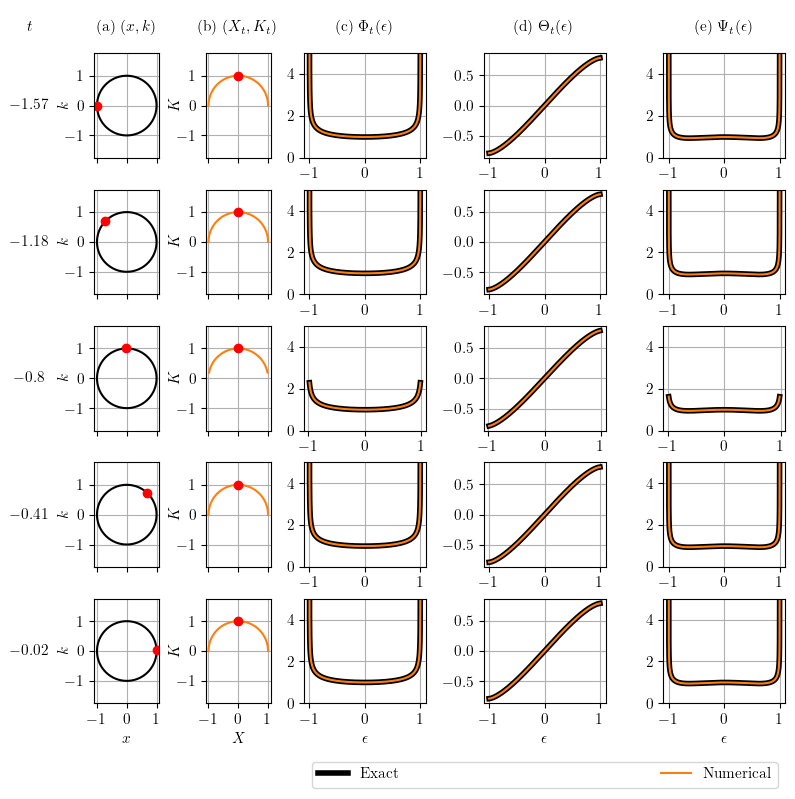

In [53]:
nrows = 2+len(sorted_results)*3
n_cols = 14
fig = plt.figure(constrained_layout=True, figsize=(19.9*cm, 20*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == len(sorted_results) - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 5), slice(5, 8), slice(8, 11), slice(11, 14)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $(X_t, K_t)$', r'(c) $\Phi_t(\epsilon)$', r'(d) $\Theta_t(\epsilon)$', r'(e) $\Psi_t(\epsilon)$']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

for i, result in enumerate(sorted_results):
    t1, it_all, mask_t1, it1, eps_rho, Xs_t1, Ks_t1, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'it1', 'eps_rho', 'Xs_t1', 'Ks_t1', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 2)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.axis('equal')
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-1, 0, 1], labels=['', '', ''])

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.axis('equal')
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], '-', alpha=0)
    ax.plot(Xs_t1.squeeze(), Ks_t1.squeeze(), '-', color='tab:orange')
    ax.plot(Xs_t1[it1], Ks_t1[it1], 'ro')
    ax.grid()
    ax.set_ylabel(r'$K$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel(r'$X$')
    else:
        ax.set_xticks([-1, 0, 1], labels=['', '', ''])
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, Phi_t1_ex(eps_rho), '-', linewidth=4, color='k')
    ax.plot(eps_rho, Phi_t1, '-', color='tab:orange')
    ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    ax.plot(eps_rho, Theta_t1_ex(eps_rho), '-', linewidth=4, color='k')
    ax.plot(eps_rho, Theta_t1, '-', color='tab:orange')
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[5]])
    ax.plot(eps_rho, np.real(Phi_t1_ex(eps_rho) * np.exp(1j*Theta_t1_ex(eps_rho))), '-', linewidth=4, color='k')
    ax.plot(eps_rho, np.real(Phi_t1 * np.exp(1j*Theta_t1)), '-', color='tab:orange')
    ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

ax = fig.add_subplot(gs[-1:, slice(col_ranges[-3].start, col_ranges[-1].stop)])
ax.plot(1, '-', color='k', linewidth=4, label='Exact')
ax.plot(1, '-', color='tab:orange', label='Numerical')
plt.axis('off')
ax.legend(mode='expand', ncols=2)

fig.savefig('./plots/weber_mgo_steps_1.pdf')
fig.savefig('./plots/weber_mgo_steps_1.png', dpi=300)
plt.show()

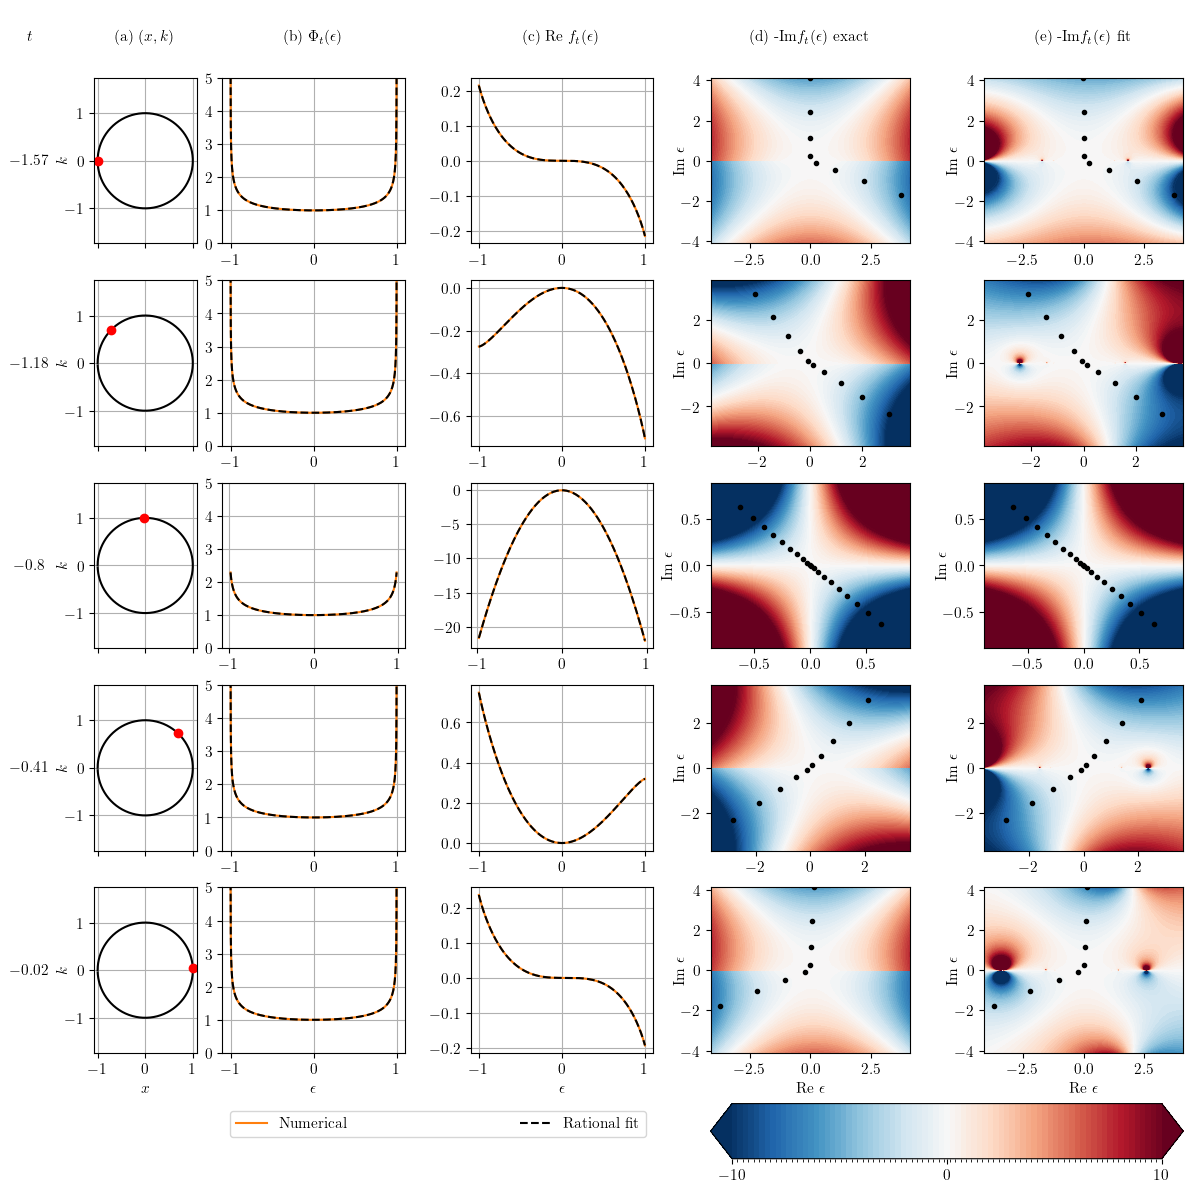

In [54]:
vmin, vmax = -10, 10
cmap = mpl.cm.RdBu_r
levels = np.linspace(vmin, vmax, 80)
norm = mpl.colors.BoundaryNorm(levels, cmap.N, extend='both')

nrows = 2+len(sorted_results)*3
n_cols = 15
fig = plt.figure(constrained_layout=True, figsize=(30*cm, 30*cm))
gs = GridSpec(nrows, n_cols, figure=fig)

def is_end(i):
    return i == len(sorted_results) - 1

def row_range(i):
        return slice(1+3*i,1+3*(i+1))

col_ranges = [slice(0, 1), slice(1, 3), slice(3, 6), slice(6, 9), slice(9, 12), slice(12, 15)]
col_titles = [r'$t$', r'(a) $(x, k)$', r'(b) $\Phi_t(\epsilon)$', r'(c) Re $f_t(\epsilon)$', r'(d) -Im$f_t(\epsilon)$ exact', r'(e) -Im$f_t(\epsilon)$ fit']

for col_range, title in zip(col_ranges, col_titles):
    ax = fig.add_subplot(gs[0, col_range])
    ax.text(0.5, 0.5, title, va="center", ha="center")
    plt.axis('off')

for i, result in enumerate(sorted_results):
    t1, it_all, mask_t1, eps_rho, Theta_t1, f_t1, f_fit, Phi_t1, g_fit, sigma_p, sigma_m, lamb, gauss_quad_order = (result[key] for key in ['t1', 'it_all', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'f_fit', 'Phi_t1', 'g_fit', 'sigma_p', 'sigma_m', 'lamb', 'gauss_quad_order'])
    eps_rho = eps_rho.squeeze()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[0]])
    ax.text(0.5, 0.5, r'$' + str(round(t1, 2)) + '$', va="center", ha="center")
    plt.axis('off')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[1]])
    ax.axis('equal')
    ax.plot(xs[i_start:i_end], ks[i_start:i_end], 'k-')
    ax.plot(xs[it_all], ks[it_all], 'ro')
    ax.grid()
    ax.set_ylabel(r'$k$', labelpad=-4)
    if is_end(i):
        ax.set_xticks([-1, 0, 1])
        ax.set_xlabel(r'$x$')
    else:
        ax.set_xticks([-1, 0, 1], labels=['', '', ''])

    ax = fig.add_subplot(gs[row_range(i), col_ranges[2]])
    ax.plot(eps_rho, Phi_t1, '-', color='tab:orange')
    ax.plot(eps_rho, g_fit(eps_rho), '--', color='k')
    ax.set_ylim(0, 5)
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')
    
    ax = fig.add_subplot(gs[row_range(i), col_ranges[3]])
    ax.plot(eps_rho, f_t1, '-', color='tab:orange')
    ax.plot(eps_rho, f_fit(eps_rho), '--', color='k')
    ax.grid()
    if is_end(i):
        ax.set_xlabel(r'$\epsilon$')

    ax = fig.add_subplot(gs[row_range(i), col_ranges[4]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_ex(Eps.reshape(-1, 1), t1).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')
    yticks = ax.get_yticks()
    ylim = ax.get_ylim()

    ax = fig.add_subplot(gs[row_range(i), col_ranges[5]])
    Eps_R, Eps_I, Eps, l_j = get_eps(lamb, gauss_quad_order)
    im_f = -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape))
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=len(levels), vmin=vmin, vmax=vmax)
    ax.contourf(Eps_R, Eps_I, im_f, cmap=cmap, levels=levels, vmin=vmin, vmax=vmax)
    ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], lamb), C_I(-l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], lamb), C_I(l_j, sigma_p[0], sigma_m[0], lamb), '.k')
    ax.set_ylabel(r'Im $\epsilon$', labelpad=-4)
    # plt.tick_params('y', labelleft=False)
    if is_end(i):
        ax.set_xlabel(r'Re $\epsilon$')

ax = fig.add_subplot(gs[-1:, slice(col_ranges[2].start, col_ranges[3].stop)])
ax.plot(1, '-', color='tab:orange', label='Numerical')
ax.plot(1, '--', color='k', label='Rational fit')
plt.axis('off')
ax.legend(mode='expand', ncols=2)

cax = fig.add_subplot(gs[-1:, slice(col_ranges[-2].start, col_ranges[-1].stop)])
c_ticks = [vmin, 0, vmax]
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cax, ticks=c_ticks, orientation='horizontal', extend='both')

fig.savefig('./plots/weber_mgo_steps_2.pdf')
fig.savefig('./plots/weber_mgo_steps_2.png', dpi=300)
plt.show()

### Other Plots

#### Comparison of $\mathcal{N}_t$ and $\Upsilon_t$

In [22]:
phi0 = field_ex(xs_ex(t))[0]
# A0_num = phi0/(Nt[0]*Upsilon[0] + Nt[-1]*Upsilon[-1] )
# A0 = phi0/(Nt_ex(t_ex)[0]*Upsilon_ex(t_ex)[0] + Nt_ex(t_ex)[-1]*Upsilon_ex(t_ex)[-1] )

fig, ax = plt.subplots(2, 3, figsize=(15, 6))

ax[0, 0].plot(t, np.real(Nt_ex(t)[0]/Nt[0] * Nt), '.', label=r'Num. Re $\mathcal{N}_t$')
ax[0, 0].plot(t, np.imag(Nt_ex(t)[0]/Nt[0] * Nt), '.', label=r'Num. Im $\mathcal{N}_t$')
ax[0, 0].legend()
ax[0, 0].grid()
# ax[0, 0].set_ylim(-5,5)

ax[0, 1].plot(t, np.real(Upsilon), '.', label=r'Num. Re $\Upsilon_t$')
ax[0, 1].plot(t, np.imag(Upsilon), '.', label=r'Num. Im $\Upsilon_t$')
ax[0, 1].legend()
ax[0, 1].grid()
ax[0, 1].set_ylim(-2, 2)

ax[0, 2].plot(t, np.real(Nt*Upsilon), '.', label=r'Num. Re $\psi_t$')
ax[0, 2].plot(t, np.imag(Nt*Upsilon), '.', label=r'Num. Im $\psi_t$')
ax[0, 2].legend()
ax[0, 2].grid()
ax[0, 2].set_ylim(-1,1)

ax[1, 0].plot(t, np.real(Nt_ex(t)), '.', label=r'Exact Re $\mathcal{N}_t$')
ax[1, 0].plot(t, np.imag(Nt_ex(t)), '.', label=r'Exact Im $\mathcal{N}_t$')
ax[1, 0].legend()
ax[1, 0].grid()
# ax[1, 0].set_ylim(-5,5)

ax[1, 1].plot(t, np.real(Upsilon_ex(t)), '.', label=r'Exact Re $\Upsilon_t$')
ax[1, 1].plot(t, np.imag(Upsilon_ex(t)), '.', label=r'Exact Im $\Upsilon_t$')
ax[1, 1].legend()
ax[1, 1].grid()
ax[1, 1].set_ylim(-2, 2)

ax[1, 2].plot(t, np.real(Nt_ex(t)*Upsilon_ex(t)), '.', label=r'Exact Re $\psi_t$')
ax[1, 2].plot(t, np.imag(Nt_ex(t)*Upsilon_ex(t)), '.', label=r'Exact Im $\psi_t$')
ax[1, 2].legend()
ax[1, 2].grid()
ax[1, 2].set_ylim(-1,1)

plt.show()

ValueError: x and y must have same first dimension, but have shapes (1327,) and (331,)

#### Inspection $\mathcal{N}_t$ Calculation

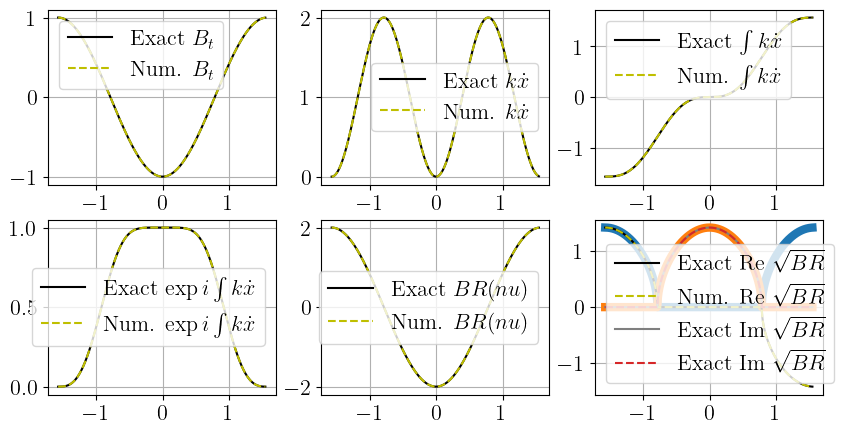

In [ ]:
import util as ut
from scipy.integrate import cumulative_trapezoid

xs_dot_ex = lambda t: - 2 * R(nu) * np.sin(2*t)
int_k_xdot_ex = lambda t: (t * (R(nu)**2) - (R(nu)**2)/4 * np.sin(4*t))
exp_i_int_k_xdot_ex = lambda t: np.exp(1j * (t * (R(nu)**2) - (R(nu)**2)/4 * np.sin(4*t)))

k_xdot_num = ut.inner_product(fd.grad(xs.squeeze(), t)[..., np.newaxis], ks)
int_k_xdot_num = cumulative_trapezoid(k_xdot_num, t, initial=0, axis=0)
int_k_xdot_num = int_k_xdot_num - int_k_xdot_num[t==0]

sqrt_body_ex = lambda t: - 2 * R(nu) * np.cos(2*t)
sqrt_body_num = np.sign(mgo_info['S'][:, 0, 1].squeeze())*np.abs(np.linalg.det(mgo_info['Lambda_rhos']) * np.linalg.det(mgo_info['A_zetas'])) * np.linalg.det(mgo_info['R'])

fig, ax = plt.subplots(2, 3, figsize=(10, 5))

ax[0, 0].plot(t, B_ex(t), 'k-', label=r'Exact $B_t$')
ax[0, 0].plot(t, mgo_info['S'][:, 0, 1], 'y--', label=r'Num. $B_t$')
ax[0, 0].legend()
ax[0, 0].grid()

ax[0, 1].plot(t, ks_ex(t)*xs_dot_ex(t), 'k-', label=r'Exact $k \dot{x}$')
ax[0, 1].plot(t, ut.inner_product(fd.grad(xs.squeeze(), t)[..., np.newaxis], ks), 'y--', label=r'Num. $k \dot{x}$')
ax[0, 1].legend()
ax[0, 1].grid()

ax[0, 2].plot(t, int_k_xdot_ex(t), 'k-', label=r'Exact $\int k \dot{x}$')
ax[0, 2].plot(t, int_k_xdot_num, 'y--', label=r'Num. $\int  k \dot{x}$')
ax[0, 2].legend()
ax[0, 2].grid()

ax[1, 0].plot(t, exp_i_int_k_xdot_ex(t), 'k-', label=r'Exact $\exp i \int k \dot{x}$')
ax[1, 0].plot(t, np.exp(1j * int_k_xdot_num), 'y--', label=r'Num. $\exp i \int k \dot{x}$')
ax[1, 0].legend()
ax[1, 0].grid()

ax[1, 1].plot(t, sqrt_body_ex(t), 'k-', label=r'Exact $BR(nu)$')
ax[1, 1].plot(t, sqrt_body_num, 'y--', label=r'Num. $BR(nu)$')
ax[1, 1].legend()
ax[1, 1].grid()

ax[1, 2].plot(t, np.real(np.emath.sqrt(sqrt_body_ex(t))), '-', linewidth=6)
ax[1, 2].plot(t, np.imag(np.emath.sqrt(sqrt_body_num)), '-', linewidth=6)
ax[1, 2].plot(t, np.real(ut.continuous_sqrt_of_reals(sqrt_body_ex(t))), 'k-', label=r'Exact Re $\sqrt{BR}$')
ax[1, 2].plot(t, np.real(ut.continuous_sqrt_of_reals(sqrt_body_num)), 'y--', label=r'Num. Re $\sqrt{BR}$')
ax[1, 2].plot(t, np.imag(ut.continuous_sqrt_of_reals(sqrt_body_ex(t))), '-', color='tab:grey', label=r'Exact Im $\sqrt{BR}$')
ax[1, 2].plot(t, np.imag(ut.continuous_sqrt_of_reals(sqrt_body_num)), '--', color='tab:red', label=r'Exact Im $\sqrt{BR}$')
ax[1, 2].legend()
ax[1, 2].grid()

plt.show()